<a href="https://colab.research.google.com/github/Kristelwen/TM10007_PROJECT/blob/master/brat_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment
Kristel, Lalot, Marijn, Tahisa

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/Kristelwen/TM10007_PROJECT

# Data loading and importing modules

In [0]:
# Importing modules
# General packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets as ds
from scipy.stats import randint

# Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

# SVM Kernels
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.decomposition import KernelPCA

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Performance metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

In [3]:
# Loading the data
from brats.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 167
The number of columns: 725


In [0]:
# Display data for analysis
data_top = data.head()
data_top 

# Preprocessing

In [0]:
# Drop columns which contain NaN values
threshold = math.floor(len(data)/2)  # calculate threshold, half of total rows
data_drop = data.dropna(thresh=threshold, axis=1)  # Delete columns/features with more than 'threshold' NaNs
data_drop = data_drop.dropna(axis=0)  # Delete rows/subjects with NaNs

# Split data and labels
labels = data_drop['label']
data_drop = data_drop.drop(columns="label")  # Data without labels

# Convert labels 'GBM' and 'LGG' to respectively 0 and 1
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split the data in a train (90%) and test set (10%)
data_train, data_test, label_train, label_test = train_test_split(data_drop, labels, test_size=0.1)
data_train2, data_val, label_train2, label_val = train_test_split(data_train, label_train, test_size=0.1)

# Feature scaling
scaler = RobustScaler()
transformer = scaler.fit(data_train.values)
data_scaled_train = transformer.transform(data_train.values)
data_df_train = pd.DataFrame(data_scaled_train, index = data_train.index, columns = data_train.columns)

data_scaled_test = transformer.transform(data_test.values)
data_df_test = pd.DataFrame(data_scaled_test, index = data_test.index, columns = data_test.columns)

# Feature selection with PCA
  # Training set
pca_train = PCA(n_components=130)  # Create a PCA with 130 components
pca_train.fit(data_scaled_train)  # Fit PCA
data_train_pca = pca_train.transform(data_scaled_train)
  # Test set
data_test_pca = pca_train.transform(data_scaled_test)  # Transform test data using PCA


# Classifiers

## k-Nearest-Neighbors

In [10]:
# Using different n_neighbors with weights = 'distance'
print('Results when weights are based on distance:')
n_neighbors=[1,5,7,10,11,15,20,50,100]
for n_neighbor in n_neighbors:
  clf = KNeighborsClassifier(n_neighbors=n_neighbor, weights='distance')
  clf.fit(data_train_pca, label_train)

  pred_train_knn = clf.predict(data_train_pca)
  acc_train_knn = accuracy_score(label_train, pred_train_knn)
  print ('Train set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))

  pred_test_knn = clf.predict(data_test_pca)
  acc_test_knn = accuracy_score(label_test, pred_test_knn)
  print ('Test set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))

# Using different n_neighbors with weights = 'uniform'
print('\n Results when weights are uniform:')
n_neighbors=[1,5,7,10,11,15,20,50,100]
for n_neighbor in n_neighbors:
  clf = KNeighborsClassifier(n_neighbors=n_neighbor, weights='uniform')
  clf.fit(data_train_pca, label_train)

  pred_train_knn = clf.predict(data_train_pca)
  acc_train_knn = accuracy_score(label_train, pred_train_knn)
  print ('Train set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))
  
  pred_test_knn = clf.predict(data_test_pca)
  acc_test_knn = accuracy_score(label_test, pred_test_knn)
  print ('Test set: {} neighbors gives an accuracy of {}'.format(n_neighbor, round(acc_train_knn,2)))

Results when weights are based on distance:
Train set: 1 neighbors gives an accuracy of 1.0
Test set: 1 neighbors gives an accuracy of 1.0
Train set: 5 neighbors gives an accuracy of 1.0
Test set: 5 neighbors gives an accuracy of 1.0
Train set: 7 neighbors gives an accuracy of 1.0
Test set: 7 neighbors gives an accuracy of 1.0
Train set: 10 neighbors gives an accuracy of 1.0
Test set: 10 neighbors gives an accuracy of 1.0
Train set: 11 neighbors gives an accuracy of 1.0
Test set: 11 neighbors gives an accuracy of 1.0
Train set: 15 neighbors gives an accuracy of 1.0
Test set: 15 neighbors gives an accuracy of 1.0
Train set: 20 neighbors gives an accuracy of 1.0
Test set: 20 neighbors gives an accuracy of 1.0
Train set: 50 neighbors gives an accuracy of 1.0
Test set: 50 neighbors gives an accuracy of 1.0
Train set: 100 neighbors gives an accuracy of 1.0
Test set: 100 neighbors gives an accuracy of 1.0

 Results when weights are uniform:
Train set: 1 neighbors gives an accuracy of 1.0
Tes

In [11]:
# Hyperparameter optimization of number of neighbors and weights

# Our parameter to optimize is the number of estimators, which we vary uniformly between 1 and 400
param_distributions = {'n_neighbors': [1,5,7,10,11,15,20,50,100], 'weights': ['uniform','distance']}  # Willen we dit toevoegen: 'bootstrap': [True, False]? Maar dan komt vgm vaak False eruit, mar die overfit. 
    
# Execute RandomizedSearchCV to find optimal parameters
clf_knn = RandomizedSearchCV(KNeighborsClassifier(), param_distributions, cv=5, random_state=42)

# Fit the classifier
clf_knn.fit(data_train_pca, label_train)

# Get the best parameters for the K-NN estimator
print(f'The best parameters found are {clf_knn.best_params_}')


The best parameters found are {'weights': 'uniform', 'n_neighbors': 1}


In [0]:
# Fitting the K-NN Classifier
KNN = KNeighborsClassifier(n_neighbors=5, weights='uniform')
KNN.fit(data_train_pca, label_train)

# Predictions
train_pred = KNN.predict(data_train_pca)
test_pred = KNN.predict(data_test_pca)

In [13]:
# Evaluate KNN using cross-validation
score_knn = cross_val_score(KNN, data_train_pca, label_train, cv=5)
mean_score_knn = score_knn.mean()

print(f'The accuracy of the validation set in 5 different folds is {score_knn}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_knn,2)}')

# Evaluate accuracy of KNN on training set
acc_train = accuracy_score(label_train, train_pred)
print(f'\n The accuracy of the training set is {round(acc_train,2)}')

# Evaluate accuracy of neural network on test set
acc_test = accuracy_score(label_test, test_pred)
print(f'\n The accuracy of the test set is {round(acc_test,2)}')

The accuracy of the validation set in 5 different folds is [0.77777778 0.84615385 0.84615385 0.76923077 0.69230769]

 The mean accuracy of the validation set of 5 different folds is 0.79

 The accuracy of the training set is 0.84

 The accuracy of the test set is 0.87


In [0]:
# Confusion matrices and classification reports
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_RF))
print(classification_report(label_train, train_pred_RF))
print("---------------------------------------------------------------\n")

print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred_RF))
print(classification_report(label_test, test_pred_RF))

## Random forest with feature_importances_ MAG WEG

Feature ranking:


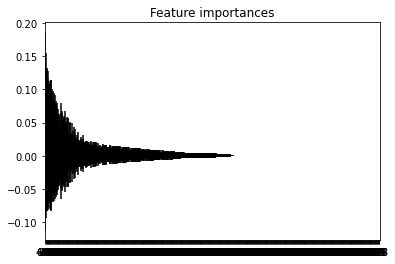

              VOLUME_ET  VOLUME_NET  ...  TGM_Cog_Z_1   TGM_T_1
ID                                   ...                       
TCGA-02-0064   0.271758   -0.029731  ...    -0.532311  0.402078
TCGA-12-1098  -0.079997   -0.434722  ...     1.116917 -0.485292
TCGA-HT-7473  -0.408568    3.882205  ...    -0.284334  0.619435
TCGA-08-0355   0.360651   -0.253516  ...    -1.182776 -0.064188
TCGA-06-0142   1.023879   -0.079470  ...    -0.592741  0.469473
...                 ...         ...  ...          ...       ...
TCGA-DU-7014  -0.552033    2.021094  ...    -0.057718 -0.254347
TCGA-06-0187   0.501751   -0.302778  ...     0.923254 -0.238357
TCGA-12-0776  -0.399830   -0.408984  ...    -0.847502 -0.631023
TCGA-DU-7294  -0.539668   -0.014757  ...     0.936686 -0.638257
TCGA-06-0149  -0.337434   -0.385026  ...    -0.444033 -0.606471

[117 rows x 396 columns]


In [0]:
# Feature selection using Feature importances 

# Feature importances
forest = RandomForestClassifier(n_estimators=15, bootstrap=True)

forest.fit(data_df_train2, label_train2)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data_df_train2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data_df_train2.shape[1]), indices)
plt.xlim([-1, data_df_train2.shape[1]])
plt.show()

# Only keep features with importance > 0.00
mask = importances > 0
mask2 = data_df_train2.columns[mask]
data_train2_sel = data_df_train2[mask2]
print(data_train2_sel)

data_val_sel = data_df_val[mask2]
data_test_sel = data_df_test[mask2]
data_train_sel = data_df_train[mask2]

## Random Forest Classifier

In [14]:
# Hyperparameter optimization: trying out different amount of trees and compare bootstrapping True and False.

#using different n_trees and bootstrapping  
print('Results when bootstrapping=True')
n_trees=[1,5,10,15,20,30,50,100,150,200]
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  clf.fit(data_train_pca,label_train)
  
  predictions_train = clf.predict(data_train_pca)
  acc_train_RF = accuracy_score(label_train, predictions_train)
  
  print ('Train set: {} trees gives an accuracy of {}'.format(n_tree, round(acc_train_RF,2)))

  predictions_test = clf.predict(data_test_pca)
  acc_test_RF = accuracy_score(label_test, predictions_test)

  print ('Test set: {} trees gives an accuracy of {}'.format(n_tree, round(acc_test_RF, 2)))

print ('')

#using different n_trees without bootstrapping 
print('Results when bootstrapping=False')
for n_tree in n_trees:
  clf = RandomForestClassifier(n_estimators=n_tree, bootstrap=False)
  clf.fit(data_train_pca,label_train)
  
  predictions_train = clf.predict(data_train_pca)
  acc_train_RF = accuracy_score(label_train, predictions_train)
  print ('Train set: {} trees gives an accuracy of {}'.format(n_tree,round(acc_train_RF,2)))

  predictions_test = clf.predict(data_test_pca)
  acc_test_RF = accuracy_score(label_test, predictions_test)

  print ('Test set: {} trees gives an accuracy of {}'.format(n_tree,round(acc_test_RF,2)))

Results when bootstrapping=True
Train set: 1 trees gives an accuracy of 0.84
Test set: 1 trees gives an accuracy of 0.73
Train set: 5 trees gives an accuracy of 0.98
Test set: 5 trees gives an accuracy of 0.93
Train set: 10 trees gives an accuracy of 0.98
Test set: 10 trees gives an accuracy of 0.8
Train set: 15 trees gives an accuracy of 0.99
Test set: 15 trees gives an accuracy of 0.87
Train set: 20 trees gives an accuracy of 1.0
Test set: 20 trees gives an accuracy of 0.8
Train set: 30 trees gives an accuracy of 1.0
Test set: 30 trees gives an accuracy of 0.8
Train set: 50 trees gives an accuracy of 1.0
Test set: 50 trees gives an accuracy of 0.73
Train set: 100 trees gives an accuracy of 1.0
Test set: 100 trees gives an accuracy of 0.8
Train set: 150 trees gives an accuracy of 1.0
Test set: 150 trees gives an accuracy of 0.73
Train set: 200 trees gives an accuracy of 1.0
Test set: 200 trees gives an accuracy of 0.87

Results when bootstrapping=False
Train set: 1 trees gives an accu

In [15]:
# Hyperparameter optimization of Random Forest Classifier

# Our parameter to optimize is the number of estimators, which we vary uniformly between 1 and 400
param_distributions = {'n_estimators': randint(1, 200)}  # Willen we dit toevoegen: 'bootstrap': [True, False]? Maar dan komt vgm vaak False eruit, mar die overfit. 
    
# Execute RandomizedSearchCV to find optimal parameters
clf_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)

# Fit the classifier
clf_rf.fit(data_train_pca, label_train)

# Get the best parameters for the Random Forest estimator
print(f'\n The best amount of trees is {clf_rf.best_params_}')


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
# Fitting the Random Forest classifier
n_trees = 15
RF = RandomForestClassifier(n_estimators=n_trees, bootstrap=True)
RF.fit(data_train_pca, label_train)

# Predictions
train_pred_RF = RF.predict(data_train_pca)
test_pred_RF = RF.predict(data_test_pca)


In [20]:
# Evaluate Random Forest using cross-validation
score_rf = cross_val_score(RF, data_train_pca, label_train, cv=5)
mean_score_rf = score_rf.mean()

print(f'\n The accuracy of the validation set in 5 different folds is {score_rf}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_rf,2)}')

# Evaluate accuracy of Random Forest Classifier on training set
acc_train_RF = accuracy_score(label_train, train_pred_RF)
print(f'\n The accuracy on the training set is {round(acc_train_RF, 2)}')

# Evaluate accuracy of Random Forest Classifier on test set
acc_test_RF = accuracy_score(label_test, test_pred_RF)
print(f'\n The accuracy on the test set is {round(acc_test_RF, 2)}')


 The accuracy of the validation set in 5 different folds is [0.85185185 0.92307692 0.92307692 0.73076923 0.76923077]

 The mean accuracy of the validation set of 5 different folds is 0.84

 The accuracy on the training set is 1.0

 The accuracy on the test set is 0.73


In [30]:
# Confusion matrices and classification reports
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_RF))
print(classification_report(label_train, train_pred_RF))
print("---------------------------------------------------------------\n")

print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred_RF))
print(classification_report(label_test, test_pred_RF))

Confusion matrix and classification report of training set
[[91  0]
 [ 0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        40

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131

Confusion matrix and classification report of test set
[[10  1]
 [ 3  1]]
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.50      0.25      0.33         4

    accuracy                           0.73        15
   macro avg       0.63      0.58      0.58        15
weighted avg       0.70      0.73      0.70        15



## Support Vector Machine

In [0]:
# VGM KAN DIT HELE BLOK WEG

#Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale') # linear kernel 
svmrbf = SVC(kernel='rbf', gamma='scale') # radial basis function kernel 
svmpoly = SVC(kernel='poly', degree=3, gamma='scale') # polynomial kernel

clsfs = [svmlin, svmrbf, svmpoly]

# for clf in clsfs: # voor alle classifiers in lijst
#    clf.fit(data_train_pca2, label_train2) # fit classifier op trainingsset
#    val = clf.predict(data_val) # test classifier op testset
#    error = (sum(abs(val - label_val))/len(data_val))*100 # hoevaak fout? 
#    error = (round(error, 2))
#    accuracy = 100 - error
    # print(f'The Accuracy of SVM is {accuracy}%')

# functie
def SVM(clsfs, data_df_train2, data_df_val, label_train2, label_val): 
    accuracies_train = list()
    accuracies_val = list()

    for clf in clsfs:
      clf.fit(data_df_train2,label_train2)
      predictions_train = clf.predict(data_df_train2)
      n_samples=len(data_df_train2)
      errors_train = (sum(abs(predictions_train - label_train2))/n_samples)*100
      errors_train = (round(errors_train, 2))
      accuracy_train=100-errors_train
      accuracies_train.append(accuracy_train)
      
      clf.fit(data_df_val,label_val)
      predictions_val = clf.predict(data_df_val)
      n_samples=len(data_df_val)
      errors_val = (sum(abs(predictions_val - label_val))/n_samples)*100
      errors_val = (round(errors_val, 2))
      accuracy_val=100-errors_val
      accuracies_val.append(accuracy_val)

    return (accuracies_train, accuracies_val)

accuracies_train, accuracies_val = SVM(clsfs, data_train_pca2, data_val_pca, label_train2, label_val)

clsfs_names = ['SVM with linear kernel', 'SVM with radial basis function kernel', 'SVM with polynomial kernel']
for num, acc_train in enumerate(accuracies_train):
    print(f'\n The accuracy of {clsfs_names[num]} is {acc_train}% for the train set and {accuracies_val[num]}% for the validation set')



 The accuracy of SVM with linear kernel is 100.0% for the train set and 100.0% for the validation set

 The accuracy of SVM with radial basis function kernel is 67.52000000000001% for the train set and 92.86% for the validation set

 The accuracy of SVM with polynomial kernel is 67.52000000000001% for the train set and 92.86% for the validation set


In [21]:
# Hyperparameter optimization of SVM

# Define parameters that need to be optimized
degrees = randint(1, 5)
coef0s = [1, 0.5, 0.01]
slacks = [0.1,1, 10, 100]
gammas = [1, 0.1 ,0.01, 0.001]
kernels = ['linear', 'rbf', 'poly']

# Creating paramater space
param_grid = {'degree': degrees,'coef0': coef0s, 'C': slacks, 'gamma': gammas, 'kernel': kernels}

# Execute RandomizedSearchCV to find optimal parameters
clf_svm = RandomizedSearchCV(SVC(),param_grid,cv=5, random_state=42, return_train_score=True)

# Fit the classifier
clf_svm.fit(data_train_pca, label_train)

# Get the best parameters for the SVM estimator
print('Best parameters found:\n', clf_svm.best_params_)


Best parameters found:
 {'C': 10, 'coef0': 1, 'degree': 3, 'gamma': 0.01, 'kernel': 'linear'}


In [0]:
# Fitting the Support Vector Machine classifier
SVM = SVC(C=10, kernel='linear', degree=3, gamma=0.01, coef0=1)
SVM.fit(data_train_pca, label_train)

# Predictions
train_pred = SVM.predict(data_train_pca)
test_pred = SVM.predict(data_test_pca)

In [26]:
# Evaluate the SVM classifier using cross-validation
score_svm = cross_val_score(SVM, data_train_pca, label_train, cv=5)
mean_score_svm = score_svm.mean()

print(f'The accuracy of the validation set in 5 different folds is {score_svm}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {round(mean_score_svm,2)}')

# Evaluate accuracy of SVM on training set
acc_train = accuracy_score(label_train, train_pred)
print(f'\n The accuracy of the training set is {round(acc_train,2)}')

# Evaluate accuracy of SVM on test set
acc_test = accuracy_score(label_test, test_pred)
print(f'\n The accuracy of the test set is {round(acc_test,2)}')


The accuracy of the validation set in 5 different folds is [0.81481481 0.92307692 0.80769231 0.84615385 0.88461538]

 The mean accuracy of the validation set of 5 different folds is 0.86

 The accuracy of the training set is 1.0

 The accuracy of the test set is 0.73


In [28]:
# Confusion matrix and classification reports
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred))
print(classification_report(label_train, train_pred))
print("---------------------------------------------------------------\n")

print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred))
print(classification_report(label_test, test_pred))

Confusion matrix and classification report of training set
[[91  0]
 [ 0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       1.00      1.00      1.00        40

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131

---------------------------------------------------------------

Confusion matrix and classification report of test set
[[9 2]
 [2 2]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.50      0.50      0.50         4

    accuracy                           0.73        15
   macro avg       0.66      0.66      0.66        15
weighted avg       0.73      0.73      0.73        15



## Neural Networks

In [34]:
# Hyperparameter optimization of Neural Network

# Define parameter space that needs to be optimized
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (7,2), (7,7,7),(9,9,9,9),(50,50,50,50), (50,50,50,50,50)],
    'activation': ['logistic','identity','tanh'], 
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
    
# Execute RandomizedSearchCV to find optimal parameters
clf_mlp = RandomizedSearchCV(MLPClassifier(max_iter=2000), parameter_space, cv=5, random_state=42, return_train_score=True)  # Verbose=2 & refit=True uitzoeken

# Fit the classifier
clf_mlp.fit(data_df_train, label_train)

# Get the best parameters for the MLP estimator
print('Best parameters found:\n', clf_mlp.best_params_)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (7, 7, 7), 'alpha': 0.05, 'activation': 'identity'}


In [0]:
# Plot the dataframe of the hyperparameter optimization
pd.DataFrame(clf_mlp.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_learning_rate,param_hidden_layer_sizes,param_alpha,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.299022,0.271891,0.004074,0.000240,adam,constant,"(7, 2)",0.05,logistic,"{'solver': 'adam', 'learning_rate': 'constant'...",0.703704,0.692308,0.692308,0.307692,0.692308,0.617664,0.155049,9,0.692308,0.695238,0.695238,0.304762,0.695238,0.616557,0.155902
1,2.478899,1.135125,0.004381,0.000071,sgd,constant,"(100,)",0.0001,tanh,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.740741,0.730769,0.692308,0.769231,0.769231,0.740456,0.028524,2,0.875000,0.828571,0.695238,0.847619,0.876190,0.824524,0.067055
2,2.187029,0.024433,0.004357,0.000265,sgd,constant,"(7, 2)",0.0001,identity,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
3,0.109056,0.051416,0.004101,0.000178,adam,adaptive,"(7, 2)",0.0001,tanh,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.333333,0.192308,0.307692,0.692308,0.692308,0.443590,0.208561,10,0.490385,0.380952,0.466667,0.695238,0.742857,0.555220,0.139447
4,1.718686,0.424521,0.004168,0.000063,adam,constant,"(7, 7, 7)",0.05,identity,"{'solver': 'adam', 'learning_rate': 'constant'...",0.777778,0.807692,0.769231,0.730769,0.769231,0.770940,0.024564,1,0.884615,0.923810,0.942857,0.942857,0.971429,0.933114,0.028624
5,0.111279,0.041251,0.004158,0.000114,adam,constant,"(7, 7, 7)",0.05,tanh,"{'solver': 'adam', 'learning_rate': 'constant'...",0.740741,0.692308,0.692308,0.653846,0.692308,0.694302,0.027587,7,0.615385,0.695238,0.714286,0.695238,0.704762,0.684982,0.035508
6,0.219620,0.142995,0.004013,0.000146,adam,adaptive,"(7, 2)",0.0001,logistic,"{'solver': 'adam', 'learning_rate': 'adaptive'...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
7,0.185261,0.109540,0.004246,0.000157,sgd,adaptive,"(7, 7, 7)",0.0001,logistic,"{'solver': 'sgd', 'learning_rate': 'adaptive',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
8,0.220436,0.104478,0.004046,0.000098,sgd,constant,"(7, 7, 7)",0.0001,logistic,"{'solver': 'sgd', 'learning_rate': 'constant',...",0.703704,0.692308,0.692308,0.692308,0.692308,0.694587,0.004558,3,0.692308,0.695238,0.695238,0.695238,0.695238,0.694652,0.001172
9,0.354048,0.037892,0.004274,0.000095,adam,constant,"(100,)",0.0001,logistic,"{'solver': 'adam', 'learning_rate': 'constant'...",0.629630,0.692308,0.692308,0.615385,0.692308,0.664387,0.034491,8,0.730769,0.685714,0.695238,0.695238,0.714286,0.704249,0.016186


In [0]:
# Fitting the Neural Network Classifier with optimal hyperparameters
MLP = MLPClassifier(solver='adam', learning_rate='constant',hidden_layer_sizes=(9,9,9,9), alpha=0.0001, activation='identity')
MLP.fit(data_df_train, label_train)

# Predictions
train_pred_MLP = MLP.predict(data_df_train)
test_pred_MLP = MLP.predict(data_df_test)


In [36]:
# Evaluate neural network using cross-validation
score = cross_val_score(MLP, data_df_train, label_train, cv=5)
mean_score = score.mean()

print(f'\n The accuracy of the validation set in 5 different folds is {score}')
print(f'\n The mean accuracy of the validation set of 5 different folds is {mean_score}')

# Evaluate accuracy of neural network on training set
acc_train = accuracy_score(label_train, train_pred_MLP)
print(f'\n The accuracy of the training set is {acc_train}')

# Evaluate accuracy of neural network on test set
acc_test = accuracy_score(label_test, test_pred_MLP)
print(f'\n The accuracy of the test set is {acc_test}')


 The accuracy of the validation set in 5 different folds is [0.85185185 0.96153846 0.92307692 0.65384615 0.84615385]

 The mean accuracy of the validation set of 5 different folds is 0.8472934472934472

 The accuracy of the training set is 0.916030534351145

 The accuracy of the test set is 0.8


In [37]:
# Confusion matrices and classification reports
print('Confusion matrix and classification report of training set')
print(confusion_matrix(label_train, train_pred_MLP))
print(classification_report(label_train, train_pred_MLP))
print("---------------------------------------------------------------\n")

print('Confusion matrix and classification report of test set')
print(confusion_matrix(label_test, test_pred_MLP))
print(classification_report(label_test, test_pred_MLP))

Confusion matrix and classification report of training set
[[87  4]
 [ 7 33]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        91
           1       0.89      0.82      0.86        40

    accuracy                           0.92       131
   macro avg       0.91      0.89      0.90       131
weighted avg       0.92      0.92      0.92       131

---------------------------------------------------------------

Confusion matrix and classification report of test set
[[9 2]
 [1 3]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.60      0.75      0.67         4

    accuracy                           0.80        15
   macro avg       0.75      0.78      0.76        15
weighted avg       0.82      0.80      0.81        15



# Learning Curves

In [0]:
# Function definition of learning curves
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt


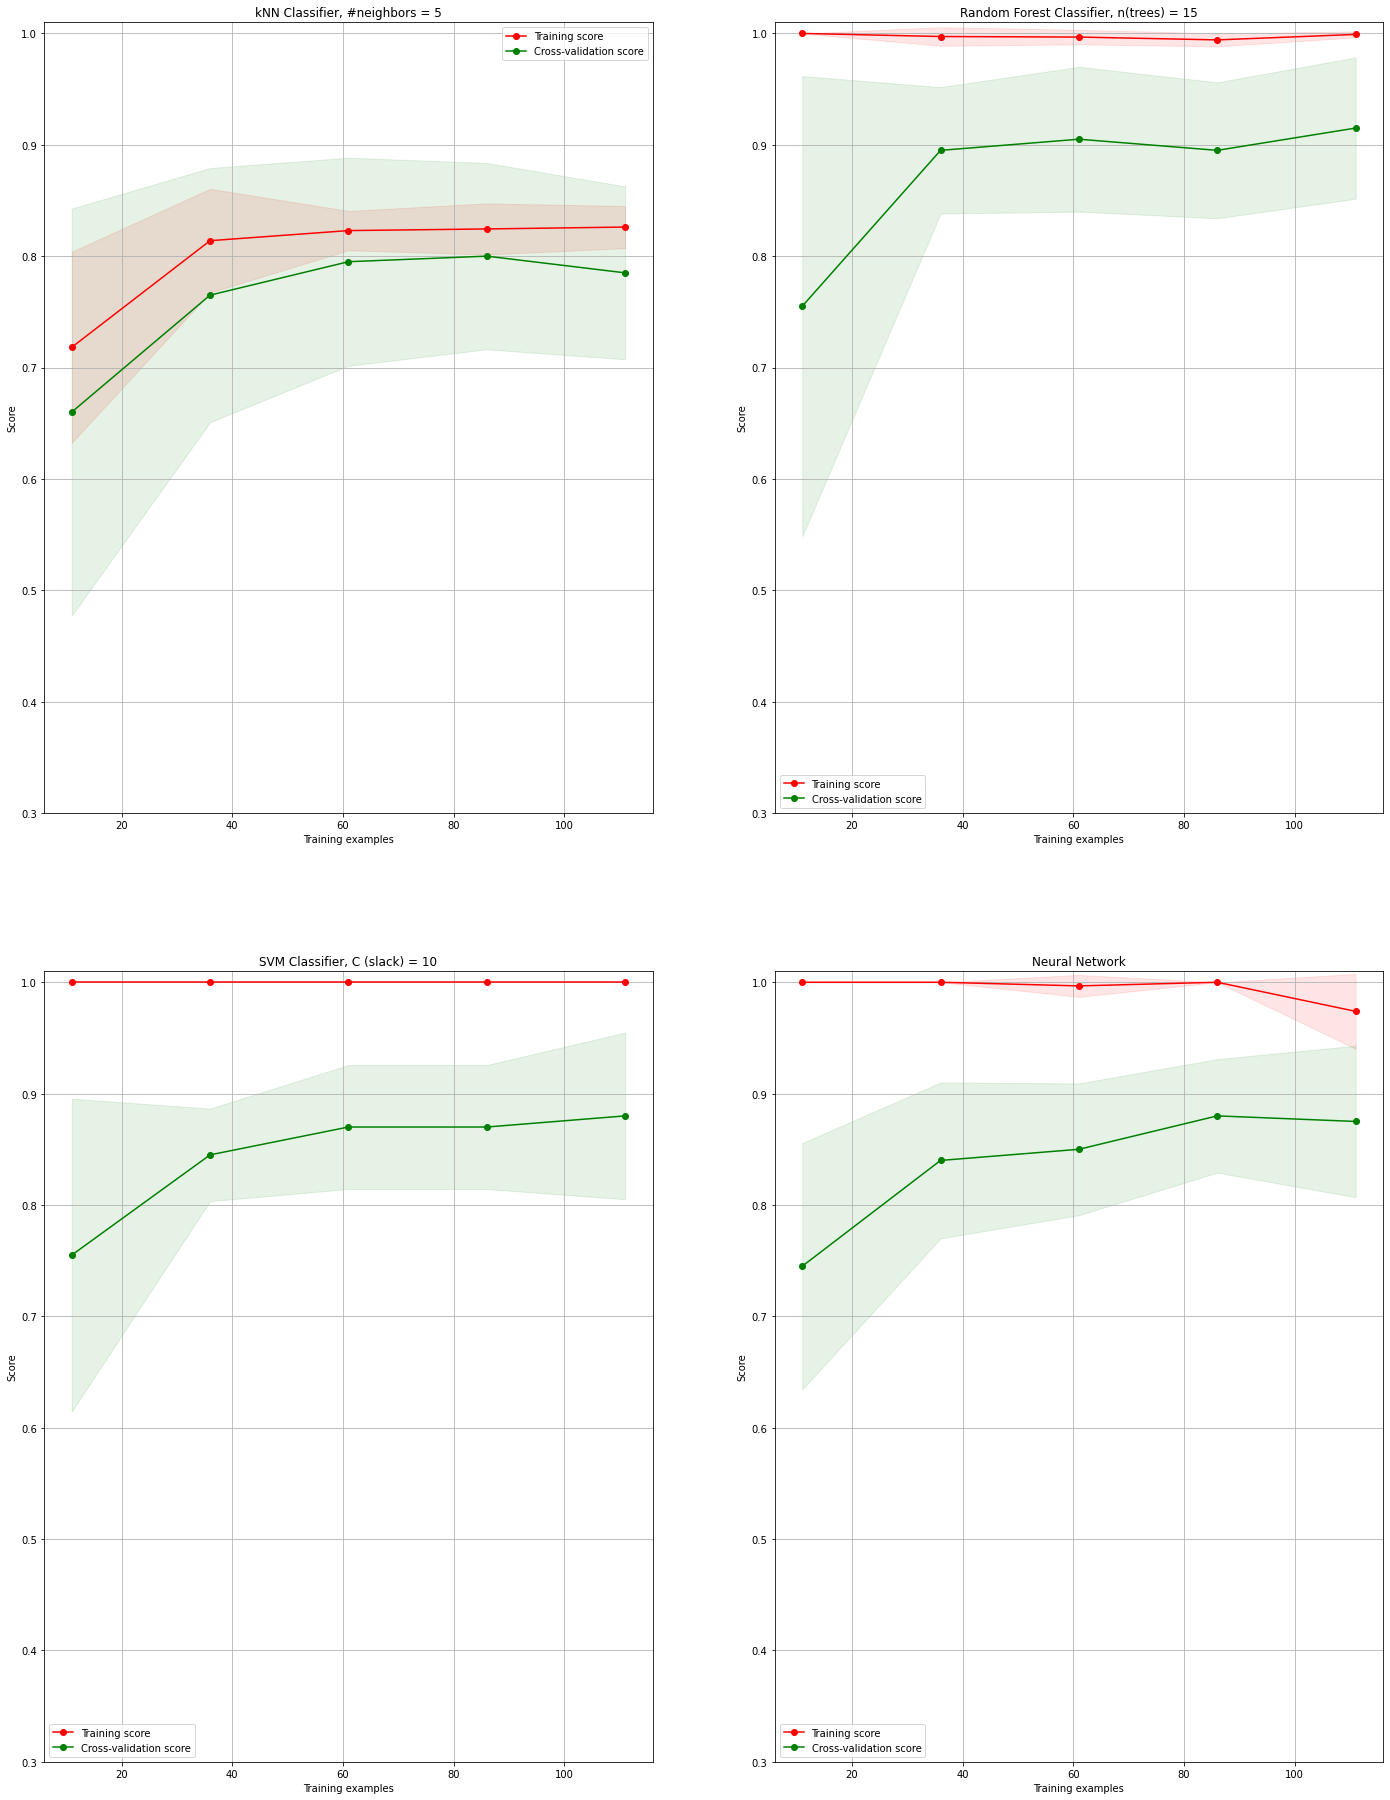

In [40]:
# Classifiers
clsfs = [KNN, RF, SVM, MLP]

# Plot figuren
fig = plt.figure(figsize=(24,8*len(clsfs)))
  
# Create a cross-validation object
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=0)
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# cv = StratifiedShuffleSplit(n_splits=10, test_size=0.15, random_state=0)

# Now use the classifiers on all datasets
num = 0
for clf in clsfs:
    # Split data in training and testing
    # title = str(type(clf))
    if hasattr(clf, 'n_estimators'):
        title = f"Random Forest Classifier, n(trees) = {clf.n_estimators}"
    elif hasattr(clf, 'C'):
        title = f"SVM Classifier, C (slack) = {clf.C}"
    elif hasattr(clf, 'n_neighbors'):
        title = f"kNN Classifier, #neighbors = {clf.n_neighbors}"
    elif hasattr(clf, 'hidden_layer_sizes'):
        title = f"Neural Network"
    ax = fig.add_subplot(2, 2, num + 1)
    plot_learning_curve(clf, title, data_df_train, label_train, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1
